In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

def download_from_drive(link, filename):
  id = link.split("/")[-2]
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={id}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={id}" -O {"/content/"+filename+".rar"} && rm -rf /tmp/cookies.txt
  !unrar x -Y {"/content/"+filename+".rar"} {"/content/"+filename+"/"}

download_from_drive("https://drive.google.com/file/d/1krZbtFXLW2711hZLq7xO0iXsUTBcwNSQ/view?usp=sharing", "data")

--2023-04-19 08:46:17--  https://docs.google.com/uc?export=download&confirm=t&id=1krZbtFXLW2711hZLq7xO0iXsUTBcwNSQ
Resolving docs.google.com (docs.google.com)... 74.125.70.138, 74.125.70.100, 74.125.70.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.70.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/idgg40tb8g3pa3t3p1dq780vepioqqqj/1681893975000/01308971736394707036/*/1krZbtFXLW2711hZLq7xO0iXsUTBcwNSQ?e=download&uuid=1418b064-ff52-427c-95c1-7ab99603e652 [following]
--2023-04-19 08:46:17--  https://doc-0s-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/idgg40tb8g3pa3t3p1dq780vepioqqqj/1681893975000/01308971736394707036/*/1krZbtFXLW2711hZLq7xO0iXsUTBcwNSQ?e=download&uuid=1418b064-ff52-427c-95c1-7ab99603e652
Resolving doc-0s-2k-docs.googleusercontent.com (doc-0s-2k-docs.googleusercontent.com)... 108.177.120.132, 260

In [ ]:
!git clone https://github.com/plasticityai/magnitude.git
%cd ./magnitude/
!python setup.py install -vvvv
%cd ../
!pip install -U lz4==1.0.0 xxhash==1.0.1 fasteners==0.17.1 annoy==1.17.1
!python -m spacy download en_core_web_sm

A streamkimeneten csak az utolsó 5000 sor látható.
    !!


    ############################
    # Package would be ignored #
    ############################
    Python recognizes 'pymagnitude.third_party.allennlp.tests.fixtures.data' as an importable package,
    but it is not listed in the `packages` configuration of setuptools.

    'pymagnitude.third_party.allennlp.tests.fixtures.data' has been automatically added to the distribution only
    because it may contain data files, but this behavior is likely to change
    in future versions of setuptools (and therefore is considered deprecated).

    Please make sure that 'pymagnitude.third_party.allennlp.tests.fixtures.data' is included as a package by using
    the `packages` configuration field or the proper discovery methods
    (for example by using `find_namespace_packages(...)`/`find_namespace:`
    instead of `find_packages(...)`/`find:`).

    You can read more about "package discovery" and "data files" on setuptools
    docu

In [ ]:
import numpy as np
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Emoji prediction

### Plan:
- Keras (TensorFlow basics)
- Read data
- Examine Data
- Apply Fasttext embedding alkalmazása (word2vec fundamentals)
- Splitting data
- Modelling with LSTM

In [ ]:
def csvloader(path):
    with open(path,"r") as f:
        lines = f.readlines()

    numlines = len(lines)
    data = []
    label = []
    for line in lines:
        data.append((line.split(";")[0]).split(" "))
        label.append(line.split(";")[-1].replace("\n",""))
    return data, label

train_data, train_label = csvloader("./data/03Emoji/train.txt")
val_data, val_label = csvloader("./data/03Emoji/val.txt")
test_data, test_label = csvloader("./data/03Emoji/test.txt")

print(train_data[:5])
print(train_label[:5])

maxlen = 0
for i in range(len(train_data)):
    sentlen = len(train_data[i])
    if sentlen>maxlen:
        maxlen=sentlen

print(maxlen)

[['i', 'didnt', 'feel', 'humiliated'], ['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake'], ['im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong'], ['i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will', 'know', 'that', 'it', 'is', 'still', 'on', 'the', 'property'], ['i', 'am', 'feeling', 'grouchy']]
['sadness', 'sadness', 'anger', 'love', 'anger']
66


im feeling rather rotten so im not very ambitious right now;sadness


im updating my blog because i feel shitty;sadness


i never make her separate from me because i don t ever want her to feel like i m ashamed with her;sadness


i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived;joy


i was feeling a little vain when i did this one;sadness

In [ ]:
from collections import Counter

print(list(zip(Counter(train_label).keys(), Counter(train_label).values())))

catlist = list(Counter(train_label).keys())
catDict = {}
catnum = len(catlist)
for i in range(catnum):
    catDict[catlist[i]]=i
print(catDict)

def onehot(x,n):
    a = np.zeros((n,))
    a[x]=1
    return a

y_train = np.array([catDict[emoji] for emoji in train_label])
y_val = np.array([catDict[emoji] for emoji in val_label])
y_test = np.array([catDict[emoji] for emoji in test_label])

[('sadness', 4666), ('anger', 2159), ('love', 1304), ('surprise', 572), ('fear', 1937), ('joy', 5362)]
{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}


In [ ]:
class_weight = {0: 1, 1: 1.5, 2: 2, 3: 5, 4: 1.5, 5: 1}

In [ ]:
import spacy
from pymagnitude import *

In [ ]:
vectors = Magnitude("./data/03Emoji/cc.en.50.magnitude")

<img src="https://miro.medium.com/max/3010/1*OEmWDt4eztOcm5pr2QbxfA.png" width=90%>

In [ ]:
result_vec = vectors.query("queen")-vectors.query("woman")+vectors.query("man")
result_vec /= np.linalg.norm(result_vec)
print(vectors.most_similar(result_vec, topn = 1))

result_vec = vectors.query("kitten")-vectors.query("cat")+vectors.query("dog")
result_vec /= np.linalg.norm(result_vec)
print(vectors.most_similar(result_vec, topn = 1))

result_vec = vectors.query("Budapest")-vectors.query("Hungary")+vectors.query("Spain")
result_vec /= np.linalg.norm(result_vec)
print(vectors.most_similar(result_vec, topn = 3))

result_vec = vectors.query("Danube")-vectors.query("Budapest")+vectors.query("London")
result_vec /= np.linalg.norm(result_vec)
print(vectors.most_similar(result_vec, topn = 1))

result_vec = vectors.query("marriage")-vectors.query("love")+vectors.query("hate")
result_vec /= np.linalg.norm(result_vec)
print(vectors.most_similar(result_vec, topn = 3))

result_vec = vectors.query("summer")-vectors.query("hot")+vectors.query("cold")
result_vec /= np.linalg.norm(result_vec)
print(vectors.most_similar(result_vec, topn = 1))

[('king', 0.8723582)]
[('puppy', 0.9156585)]
[('Barcelona', 0.89337003), ('Madrid', 0.88811415), ('Sitges', 0.8445297)]
[('Thames', 0.8253575)]
[('divorce', 0.76304775), ('abortion', 0.7568837), ('divorces', 0.7423908)]
[('winter', 0.85631716)]


- Coding the data to vectors

In [ ]:
x_train = vectors.query(train_data, pad_to_length=70)
x_val = vectors.query(val_data, pad_to_length=70)
x_test = vectors.query(test_data, pad_to_length=70)

- Randomize order

In [ ]:
def randomize_data(data,label):
    idx = np.random.permutation(data.shape[0])
    data = data[idx,...]
    label = label[idx,...]
    return data, label

x_train, y_train = randomize_data(x_train, y_train)
x_val, y_val = randomize_data(x_val, y_val)
x_test, y_test = randomize_data(x_test, y_test)

<img src=https://www.researchgate.net/profile/Savvas-Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg>

<img src=https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/bilstm-1-1024x384.png>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History, EarlyStopping

In [ ]:
inp = Input(shape=(70, 50)) # (batch_size), seq_len, seq_dim
x = Bidirectional(LSTM(128, dropout=0.1, return_sequences=True))(inp) # (batch_size), 70, 128
x = Bidirectional(LSTM(128, dropout=0.1))(x) # (batch_size), 128
x = Dense(32, activation='tanh')(x) # (batch_size), 32
x = Dense(6, activation='softmax')(x) # (batch_size), 6
model = Model([inp],[x])

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
hist = History()
earlystop = EarlyStopping(monitor='val_loss', min_delta=2e-4, patience=10, verbose=1,
    mode='min', restore_best_weights=True)

In [ ]:
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[hist, earlystop],
          verbose=2, class_weight=class_weight)

Epoch 1/100
500/500 - 17s - loss: 2.2754 - accuracy: 0.4179 - val_loss: 1.4511 - val_accuracy: 0.4775 - 17s/epoch - 35ms/step
Epoch 2/100
500/500 - 9s - loss: 2.1181 - accuracy: 0.4726 - val_loss: 1.4562 - val_accuracy: 0.4380 - 9s/epoch - 17ms/step
Epoch 3/100
500/500 - 7s - loss: 2.0591 - accuracy: 0.4738 - val_loss: 1.3664 - val_accuracy: 0.4915 - 7s/epoch - 14ms/step
Epoch 4/100
500/500 - 8s - loss: 2.0047 - accuracy: 0.4777 - val_loss: 1.3335 - val_accuracy: 0.4985 - 8s/epoch - 17ms/step
Epoch 5/100
500/500 - 8s - loss: 1.9659 - accuracy: 0.4759 - val_loss: 1.3462 - val_accuracy: 0.4920 - 8s/epoch - 16ms/step
Epoch 6/100
500/500 - 8s - loss: 1.9311 - accuracy: 0.4860 - val_loss: 1.2933 - val_accuracy: 0.4975 - 8s/epoch - 17ms/step
Epoch 7/100
500/500 - 7s - loss: 1.8989 - accuracy: 0.4919 - val_loss: 1.3717 - val_accuracy: 0.4515 - 7s/epoch - 13ms/step
Epoch 8/100
500/500 - 8s - loss: 1.8713 - accuracy: 0.4989 - val_loss: 1.2641 - val_accuracy: 0.5120 - 8s/epoch - 16ms/step
Epoch 

In [ ]:
!nvidia-smi

Wed Apr 19 09:25:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |   1777MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model.evaluate(x_test,y_test)

63/63 [==============================] - 1s 10ms/step - loss: 0.6681 - accuracy: 0.7540


[0.6680800318717957, 0.7540000081062317]

In [ ]:
from tensorflow.math import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

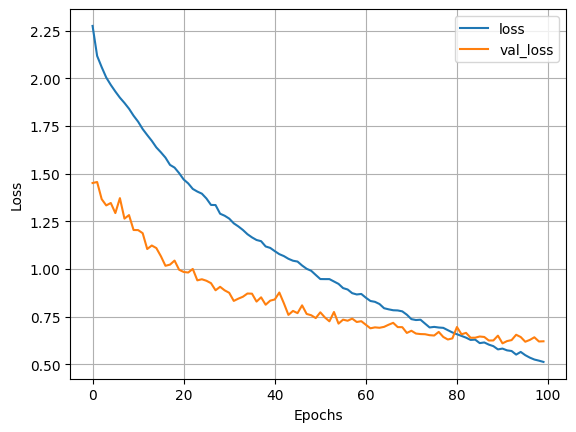

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(["loss","val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

63/63 [==============================] - 43s 10ms/step


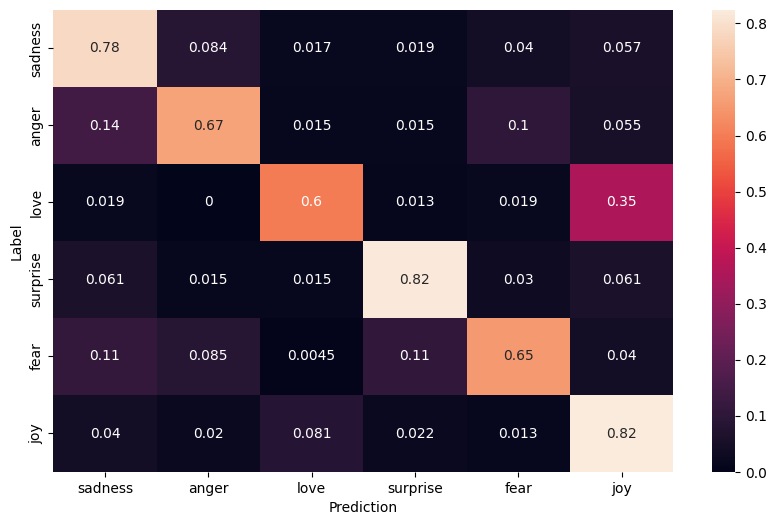

In [ ]:
conf_mat = confusion_matrix(
    y_test,
    np.argmax(model.predict(x_test), axis=1).flatten())

conf_mat /= np.sum(conf_mat, axis=1).reshape(-1,1)

plt.figure(0,figsize=(10,6))
sns.heatmap(conf_mat, xticklabels=catDict.keys(), yticklabels=catDict.keys(), annot=True)
plt.ylabel("Label")
plt.xlabel("Prediction");

In [ ]:
def emoji_tester(model, embedding, text):
    catDictInverse = {0:"😓",1:"👿",2:"🥰",3:"😲",4:"😱",5:"😃"}
    net_input = embedding.query([text.lower().split(" ")], pad_to_length=70)
    net_output = model.predict(net_input)
    emoji = catDictInverse[np.argmax(net_output)]
    print(emoji)

In [ ]:
emoji_tester(model, vectors, "I am in love with NLP I can't live without it")

1/1 [==============================] - 0s 45ms/step
😃


In [ ]:
for idx, label in enumerate(test_label):
  if label == "love":
    print(idx)

14
71
74
79
96
111
125
131
149
151
166
167
168
170
183
201
202
206
228
241
254
265
286
292
294
302
303
307
316
326
333
341
355
356
366
369
391
404
466
513
520
529
535
574
575
593
595
608
614
615
621
627
629
630
643
650
670
713
715
735
746
765
766
802
821
833
869
886
888
890
894
895
909
923
936
957
959
960
978
982
985
992
994
1013
1015
1017
1059
1061
1064
1072
1081
1083
1092
1111
1117
1123
1146
1178
1194
1207
1216
1245
1301
1333
1340
1346
1347
1358
1370
1377
1381
1386
1387
1395
1402
1436
1458
1463
1476
1478
1488
1497
1513
1524
1541
1545
1571
1588
1592
1642
1650
1680
1684
1685
1701
1709
1714
1731
1732
1739
1745
1756
1765
1818
1833
1836
1844
1849
1851
1889
1899
1902
1936
1945
1961
1969
1970
1990
1991


In [ ]:
test_data[1899]

['ive',
 'got',
 'a',
 'off',
 'sale',
 'the',
 'ad',
 'says',
 'starting',
 'tomorrow',
 'but',
 'im',
 'feeling',
 'generous',
 'and',
 'started',
 'it',
 'now']